In [171]:
import numpy as np
import pandas as pd
import random
import copy
import os

from math import sqrt, log
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.spatial
from haversine import haversine

import warnings
warnings.filterwarnings('ignore')

# Download datasets

In [172]:
times = pd.read_csv(rf'./files/times v4.csv', sep=',')
lenght = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='TIDS')
income = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='Incomes')

income = income.set_index('TID')
lenght = lenght.set_index('TID')

random.seed(42)

Строим матрицу расстояний на основе времени между банкоматами

In [173]:
distance_matrix = times.pivot_table(index = 'Origin_tid', columns = 'Destination_tid', values = 'Total_Time')
distance_matrix = distance_matrix.fillna(0)

# Visualisation

Визуализируем местонахождение банкоматов

In [174]:
class Visualisation:
    def __init__(self, df: pd.DataFrame, n_squares: int=4):
        self.df = df
        self.n_squares = n_squares


    @staticmethod
    def get_divisors(number):
        result = {1, number}
        for divisor in range(2, number // 2  + 1):
            if number % divisor == 0:
                result.add(divisor)

        result = list(sorted(result))
        lenght_list = len(result)//2

        return result[lenght_list-1:lenght_list+1]
    

    def separation_to_squares(self, df: pd.DataFrame, n_squares: int=4) -> dict:

        '''
            if n_squares is not power of 2, separetion will be separate for bigger different of metrics
        '''
        if n_squares < 0:
            print('Separation number is negative')
            return {}
        
        north = df.longitude.max()
        south = df.longitude.min()
        east = df.latitude.max()
        west = df.latitude.min()

        result = dict()

        '''
            search divisors for separetion of square
        '''
        if n_squares ** .5 == int(n_squares ** .5):
            multiplies = [int(sqrt(n_squares))-1]*2
        else:
            multiplies = self.get_divisors(n_squares)
            if multiplies[0] == 1:
                print('Primal number!')
                return result

        '''
            determine the position vaertical or horizontal
        '''
        if (north - south) > (east - west):
            position = 'vertical'
        else:
            position = 'horizontal'


        minimal = multiplies[0]+1
        maximal = multiplies[1]+1
        if multiplies[0] != multiplies[1]:
            if (n_squares != 0) and (n_squares & (n_squares-1) == 0):
                    if position == 'vertical':
                        result['longitude'] = list(np.linspace(north, south, minimal))
                        result['latitude'] = list(np.linspace(east, west, maximal))
                    else:
                        result['longitude'] = list(np.linspace(east, west, maximal))
                        result['latitude'] = list(np.linspace(north, south, minimal))
            else:
                if position == 'vertical':
                    result['longitude'] = list(np.linspace(north, south, minimal))
                    result['latitude'] = list(np.linspace(east, west, maximal))
                else:
                    result['longitude'] = list(np.linspace(east, west, maximal))
                    result['latitude'] = list(np.linspace(north, south, minimal))
        else:
            if position == 'vertical':
                result['longitude'] = list(np.linspace(north, south, minimal+1))
                result['latitude'] = list(np.linspace(east, west, maximal+1))
            else:
                result['longitude'] = list(np.linspace(east, west, maximal+1))
                result['latitude'] = list(np.linspace(north, south, minimal+1))

        result['longitude'] = result['longitude'][1:-1]
        result['latitude'] = result['latitude'][1:-1]
        result['side'] = {'north': north, 'south': south, 'east': east, 'west': west}

        return result
    

    def visualisation_of_squares(self) -> dict:
        if self.n_squares < 0:
            print('Separation number is negative')
            return dict()
        multiplies = self.get_divisors(self.n_squares)
        if multiplies[0] == 1 and not (self.n_squares ** .5 == int(self.n_squares ** .5)):
            print('Primal number!')
            return dict()
        
        result = self.separation_to_squares(self.df, self.n_squares)

        fig, axes = plt.subplots(figsize=(12, 12))
        axes.scatter(data=self.df, x='latitude', y='longitude')

        for x in result['latitude']:
            axes.plot(np.array([x, x]), np.array([result['side']['south'], result['side']['north']]), color='red')

        for x in result['longitude']:
            axes.plot(np.array([result['side']['west'], result['side']['east']]), np.array([x, x]), color='red')
            
        axes.set_xlabel('latitude')
        axes.set_ylabel('longitude')

        return result

{'longitude': [37.67150887],
 'latitude': [55.608132735],
 'side': {'north': 39.84245897,
  'south': 35.50055877,
  'east': 56.75784253,
  'west': 54.45842294}}

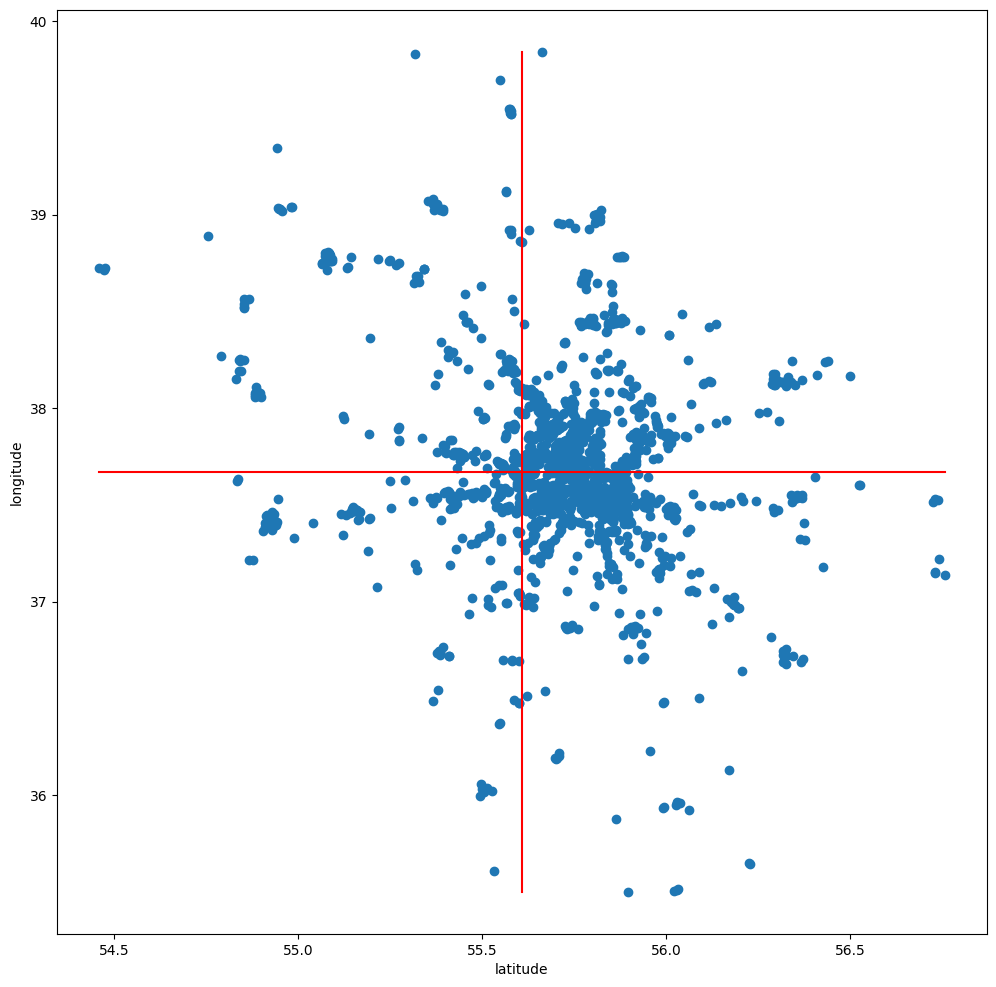

In [175]:
Visualisation(lenght, 4).visualisation_of_squares()

# Math model

In [176]:
model = copy.deepcopy(income)
RUB = 10**6
days = 14
month_day = 30
downtime = 10
alfa = .93
cars = 4

In [177]:
tmp = list(income.columns)[1:]
model['sum'] = model[tmp].sum(axis=1)
model['mean'] = model[tmp].mean(axis=1)
model['std'] = model[tmp].std(axis=1)
model = model.drop(columns=tmp)

model['day'] = RUB/model['mean']
model['day_with_limit'] = np.where(model.day>=14, 14, model.day)
model['number_trips'] = month_day/model.day_with_limit
model['limit'] = model['day_with_limit'].round(0)
model['quantity'] = 1

In [178]:
pivotmodel2 = model.groupby(by='limit')[['quantity']].sum().reset_index()
pivotmodel2['loop'] = pivotmodel2.quantity / pivotmodel2.limit.max()
pivotmodel2['case_loop'] = pivotmodel2.limit.max() / pivotmodel2.limit
pivotmodel2['category'] = np.where(pivotmodel2.loop > 5, 'b', 'a')

In [179]:
model = model.reset_index().merge(pivotmodel2[['limit', 'category']], on='limit', how='left')
model = model.set_index('TID')

# K-Means Classtering

In [180]:
class Clastering():

    def __init__(self, df: pd.DataFrame, case: str, claster_limit: float, figsize: tuple=(5,3)):
        self.df = df
        self.case = case
        self.claster_limit = claster_limit
        self.__k = claster_limit+1
        self.figsize = figsize


    def distance(self, p1, p2):
        return haversine(p1[1:],p2[1:])
    

    def cluster_centroids(self, vals, clusters, k):
        results=[]
        for i in range(k):
            results.append(np.average(vals[clusters == i],weights=np.squeeze(np.asarray(vals[clusters == i][:,[0]])),axis=0))
        return results


    def kmeans(self, vals, k=None, centroids=None, steps=20):
        centroids = vals[np.random.choice(np.arange(len(vals)), k, False)]
        elbow = []
        for _ in range(max(steps, 1)):
            sqdists = scipy.spatial.distance.cdist(centroids, vals, lambda u, v: (self.distance(u,v)**2))
            elbow.append(sqdists)
            clusters = np.argmin(sqdists, axis=0)
            new_centroids = self.cluster_centroids(vals, clusters, k)
            if np.array_equal(new_centroids, centroids):
                break
            centroids = new_centroids
        return clusters, centroids, elbow


    def SSE(self) -> dict:
        vals = self.df[[self.case,'latitude','longitude']].values
        sse=[]
        data = {}
        try:
            for k in range(1,self.__k):
                clusters, centroids, elbow=self.kmeans(vals, k)
                sqdist = np.sum((elbow-np.mean(elbow))**2)
                sse.append(sqdist)
                data[k] = {'clusters': clusters, 'centroids': centroids, 'elbow': elbow}

            sse=sorted(sse,reverse=True)
            return {'sse': sse, 'data': data}
        except Exception:
            return self.SSE()

    def define_claster_limit(self, sse: list) -> list[int]:
        return [self.claster_limit, sse[self.claster_limit-1]]
        # for x in sse:
        #     if x <= self.claster_limit:
        #         c.append(sse.index(x)+1)
        #         c.append(x)
        #         return c

    
    def visualisation_claster(self) -> dict:
        df = self.SSE()
        sse = df['sse']
        fig = plt.figure(figsize=(5,3))
        c = self.define_claster_limit(sse)
        x=list(range(1,self.__k))
        labels=x
        plt.plot(x,sse,'r')
        plt.scatter(x,sse,marker='x')
        plt.xticks(x, labels)
        plt.title('Elbow Method')
        plt.xlabel('K')
        plt.ylabel('SSE Distance')
        plt.plot([c[0], c[0]], [0, c[1]], color='green', linestyle='dashed', linewidth=2)  # plotting the arbitrary line from point (25,10) to (65,45).    
        plt.show()
        df['clester_count'] = c[0]
        return df


    def selections(self):
        scce = self.visualisation_claster()
        data = scce['data'][scce['clester_count']]

        self.df['c']=[int(c) for c in data['clusters']]

        lats = [data['centroids'][i][1] for i in range(scce['clester_count'])]
        self.df['clat'] = self.df['c'].map(lambda x: lats[x])

        longs = [data['centroids'][i][2] for i in range(scce['clester_count'])]
        self.df['clong'] = self.df['c'].map(lambda x: longs[x])

        return self.df, scce
    

    @staticmethod
    def plot_clasters(df, k):
        c_lat=list(set(df['clat']))
        c_long=list(set(df['clong']))

        fig, ax = plt.subplots(figsize=(10, 6))
        colors = ['gold', 'cornflowerblue', 'limegreen', 'violet', 'pink', 
                  'brown', 'salmon', 'aqua', 'olive', 'chocolate',
                  'indigo', 'orchid', 'silver', 'peru', 'navu']
        for x in range(k):
            x1=df.query(f'c=={x}')['latitude'].values.tolist()
            y1=df.query(f'c=={x}')['longitude'].values.tolist()
            plt.scatter(y1,x1, color=colors[x])
        plt.scatter(c_long,c_lat,marker='x', color='black')
        plt.show()
        

In [181]:
A_category = lenght.merge(model.query('category == "a"')[['number_trips']], left_index=True, right_index=True, how='inner')
B_category = lenght.merge(model.query('category == "b"')[['number_trips']], left_index=True, right_index=True, how='inner')

In [182]:
A_category = Clastering(A_category, 'number_trips', 14)
B_category = Clastering(B_category, 'number_trips', 14)

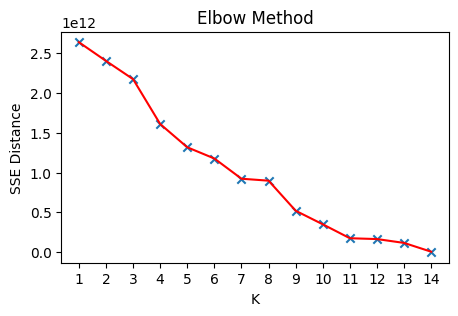

In [183]:
A_category, scce = A_category.selections()
#Clastering.plot_clasters(A_category, scce['clester_count'])

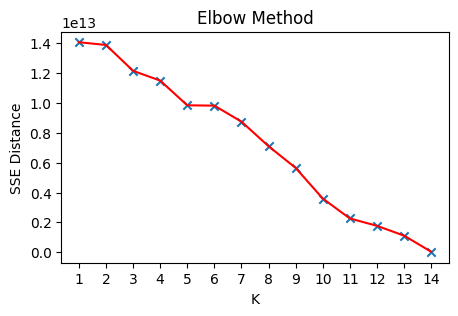

In [184]:
B_category, scce = B_category.selections()
#Clastering.plot_clasters(B_category, scce['clester_count'])

# K-Means Classtering (added)

In [185]:
A_category = A_category.reset_index()
B_category = B_category.reset_index()
model_added = copy.deepcopy(model)

In [186]:
A_claster = times.merge(A_category[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
A_claster = A_claster.merge(A_category[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

B_claster = times.merge(B_category[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
B_claster = B_claster.merge(B_category[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

In [187]:
A_claster = A_claster.query('c_x==c_y').drop(columns=['TID_x', 'TID_y', 'c_y']).rename(columns={'c_x': 'cluster'})
B_claster = B_claster.query('c_x==c_y').drop(columns=['TID_x', 'TID_y', 'c_y']).rename(columns={'c_x': 'cluster'})


In [188]:
l = pd.DataFrame({
      'Mean Time': A_claster.query(f'cluster=={x}').Total_Time.mean(), 
      'Number of points': A_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
      'Time %': (A_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * A_claster.query(f'cluster=={x}').Total_Time.mean(),
      'Number of cluster': x} for x in range(scce['clester_count']))
print(l['Mean Time'].mean())
print(l['Number of points'].sum())
print(l['Number of points'].mean())
l['Total time A'] = l['Mean Time'] * l['Number of points']
l['Total time A / 720'] = l['Total time A'] / 720
print(l['Total time A'].mean())
print(l['Total time A / 720'].mean())
print()
print(l)

34.521779373779154
337
24.071428571428573
641.1186298851508
0.8904425415071539

    Mean Time  Number of points    Time %  Number of cluster  Total time A  \
0   15.893019                46  0.448515                  0    731.078889   
1   28.711667                 9  0.158531                  1    258.405000   
2   38.798772                19  0.452256                  2    737.176667   
3   26.130552                30  0.480930                  3    783.916552   
4   55.606429                 7  0.238801                  4    389.245000   
5   12.982933                35  0.278775                  5    454.402647   
6   26.300227                35  0.564729                  6    920.507941   
7   45.863333                 6  0.168822                  7    275.180000   
8   53.125667                10  0.325924                  8    531.256667   
9   56.455571                15  0.519530                  9    846.833571   
10  41.414286                15  0.381113                 10  

In [189]:
l = pd.DataFrame({
      'Mean Time': B_claster.query(f'cluster=={x}').Total_Time.mean(), 
      'Number of points': B_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
      'Time %': (B_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * B_claster.query(f'cluster=={x}').Total_Time.mean(),
      'Number of cluster': x} for x in range(scce['clester_count']))

print(l['Mean Time'].mean())
print(l['Number of points'].sum())
print(l['Number of points'].mean())
l['Total time B'] = l['Mean Time'] * l['Number of points']
l['Total time B / 720'] = l['Total time B'] / 720
print(l['Total time B'].mean())
print(l['Total time B / 720'].mean())
print()
print(l)

35.33256620396857
1293
92.35714285714286
2713.8844970462715
3.769284023675378

    Mean Time  Number of points    Time %  Number of cluster  Total time B  \
0   54.867379                27  0.908846                  0   1481.419231   
1   32.107572                73  1.437946                  1   2343.852778   
2   40.017052                57  1.399369                  2   2280.971964   
3   19.573924               242  2.906067                  3   4736.889627   
4   32.501031                88  1.754657                  4   2860.090690   
5   44.773568                56  1.538233                  5   2507.319818   
6   37.468305                41  0.942454                  6   1536.200500   
7   30.416922                51  0.951695                  7   1551.263000   
8   21.765177                94  1.255170                  8   2045.926667   
9   55.312548                60  2.036045                  9   3318.752881   
10  55.161522                44  1.489023                 10   

In [190]:
A_model = model_added.merge(A_claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'cluster']], left_index=True, right_index=True, how='inner')
B_model = model_added.merge(B_claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'cluster']], left_index=True, right_index=True, how='inner')

In [191]:
A_model['downtime'] = downtime * 60
A_model['Common_Time'] = A_model[['Total_Time', 'downtime']].sum(axis=1)
A_model['Car_per_minute'] = 20000/(12*60)
A_model['Maintenance_cost_one_time'] = A_model['Common_Time']/60 * A_model['Car_per_minute']
A_model['Maintenance_cost_per_month'] = A_model['number_trips'] * A_model['Maintenance_cost_one_time']
A_model['Car_time'] = A_model['number_trips'] * A_model['Common_Time']/60
((A_model.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

324582.103015873

In [192]:
B_model['downtime'] = downtime * 60
B_model['Common_Time'] = B_model[['Total_Time', 'downtime']].sum(axis=1)
B_model['Car_per_minute'] = 20000/(12*60)
B_model['Maintenance_cost_one_time'] = B_model['Common_Time']/60 * B_model['Car_per_minute']
B_model['Maintenance_cost_per_month'] = B_model['number_trips'] * B_model['Maintenance_cost_one_time']
B_model['Car_time'] = B_model['number_trips'] * B_model['Common_Time']/60
((B_model.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

795142.6203922465

# Reesrt of routes

In [193]:
income.columns = pd.to_datetime(income.columns).date
B_income = B_claster.drop_duplicates(subset='Origin_tid', keep='first').rename(columns={'Origin_tid': 'TID'}).set_index('TID')[['cluster']].merge(income, left_index=True, right_index=True, how='left')
A_income = A_claster.drop_duplicates(subset='Origin_tid', keep='first').rename(columns={'Origin_tid': 'TID'}).set_index('TID')[['cluster']].merge(income, left_index=True, right_index=True, how='left')

A_income = model.query('category == "a"')[['mean', 'std', 'limit', 'category']].merge(A_income, left_index=True, right_index=True, how='left')
B_income = model.query('category == "b"')[['mean', 'std', 'limit', 'category']].merge(B_income, left_index=True, right_index=True, how='left')

start = B_income.columns[5]

In [194]:
B_residue = B_income[[start, 'limit', 'cluster', 'mean', 'std', 'category']].reset_index()
B_residue['Date'] = start
B_residue['cluster'] += 1
B_residue['Number_day'] = 0
B_residue = B_residue.rename(columns={start: 'Balance_close'})
B_reestr = pd.DataFrame([], columns=['TID', 'limit', 'cluster', 'Balance_open', 'Income', 'Outcome', 'Balance_close', 'Date', 'Number_day_form_last_serves', 'Number_day', 'mean', 'std', 'category'])
B_reestr = pd.concat([B_reestr, B_residue]).fillna(0)

In [195]:
A_residue = A_income[[start, 'limit', 'cluster', 'mean', 'std', 'category']].reset_index()
A_residue['Date'] = start
A_residue['cluster'] += 1
A_residue['Number_day'] = 0
A_residue = A_residue.rename(columns={start: 'Balance_close'})
A_reestr = pd.DataFrame([], columns=['TID', 'limit', 'cluster', 'Balance_open', 'Income', 'Outcome', 'Balance_close', 'Date', 'Number_day_form_last_serves', 'Number_day', 'mean', 'std', 'category'])
A_reestr = pd.concat([A_reestr, A_residue]).fillna(0)

### Depends on points' number

In [196]:
if False:
    counter = B_income.shape[0]//(14)
    A_counter = A_income.shape[0]//(14)
    for x in list(B_income.columns)[4:]:
        lastday_tmp = x-dt.timedelta(days=1)

        # B category
        B_income_tmp = B_income[[x]].reset_index().rename(columns={x: 'Income'})

        
        B_nextday_tmp = B_reestr.query(f'Date == @lastday_tmp')
        B_nextday_tmp['Date'] += dt.timedelta(days=1)
        B_nextday_tmp = B_nextday_tmp.drop(columns='Income').merge(B_income_tmp, on='TID', how='inner')

        B_nextday_tmp['Balance_open'] = B_nextday_tmp['Balance_close']
        B_nextday_tmp['Balance_close'] = 0

        B_nextday_tmp['Number_day'] += 1
        B_nextday_tmp['Number_day_form_last_serves'] += 1


        B_nextday_tmp['Outcome'] = np.where(((B_nextday_tmp.Balance_open >= RUB) | 
                                            (B_nextday_tmp.Number_day == B_nextday_tmp.cluster) | 
                                            (B_nextday_tmp.Number_day_form_last_serves > 14)) & 
                                            (RUB*(A_income.shape[0]/B_income.shape[0]) <  B_nextday_tmp.Balance_open), 
                                            B_nextday_tmp.Balance_open, 0)

        #((B_nextday_tmp['mean'] + B_nextday_tmp['std'])*2 < B_nextday_tmp.Balance_open)
        #(RUB*(A_income.shape[0]/B_income.shape[0]) < B_nextday_tmp.Balance_open)
        B_nextday_tmp['Number_day'] = np.where((B_nextday_tmp.Number_day > 14), 1, B_nextday_tmp.Number_day)
        B_nextday_tmp['Number_day_form_last_serves'] = np.where((B_nextday_tmp.Outcome != 0), 1, B_nextday_tmp.Number_day_form_last_serves)
        
        B_nextday_tmp['Balance_close'] = B_nextday_tmp.Balance_open + B_nextday_tmp.Income - B_nextday_tmp.Outcome

        B_reestr = pd.concat([B_reestr, B_nextday_tmp]).fillna(0).reset_index(drop=True)

        limit = B_reestr.query('Date == @x and Outcome != 0').shape[0]
        if limit < counter:
            potencial = list(B_reestr.query(f'Date == @x and Outcome == 0 and cluster == {int(int(x.day)%14)+1}').sort_values(by='Balance_open', ascending=False).Id)[:int(counter-limit)]
            if potencial != []:
                B_reestr.loc[(B_reestr.Date == x) & 
                            (B_reestr.TID.isin(potencial)), 'Outcome'] = B_reestr.Balance_open
                B_reestr.loc[(B_reestr.TID.isin(potencial)) & (B_reestr.Date == x), 'Balance_close'] = B_nextday_tmp.Balance_open + B_nextday_tmp.Income - B_nextday_tmp.Outcome
                B_reestr.loc[(B_reestr.TID.isin(potencial)) & (B_reestr.Date == x), 'Number_day'] = 1
                B_reestr.loc[(B_reestr.TID.isin(potencial)) & (B_reestr.Date == x), 'Number_day_form_last_serves'] = 1

        # A category
        A_income_tmp = A_income[[x]].reset_index().rename(columns={x: 'Income'})
        
        A_nextday_tmp = A_reestr.query(f'Date == @lastday_tmp')
        A_nextday_tmp['Date'] += dt.timedelta(days=1)
        A_nextday_tmp = A_nextday_tmp.drop(columns='Income').merge(A_income_tmp, on='TID', how='inner')

        A_nextday_tmp['Balance_open'] = A_nextday_tmp['Balance_close']
        A_nextday_tmp['Balance_close'] = 0

        A_nextday_tmp['Number_day'] += 1
        A_nextday_tmp['Number_day_form_last_serves'] += 1


        A_nextday_tmp['Outcome'] = np.where(((A_nextday_tmp.Balance_open >= RUB) | 
                                            (A_nextday_tmp.Number_day_form_last_serves == A_nextday_tmp.cluster) | 
                                            (A_nextday_tmp.Number_day_form_last_serves > 14)) & 
                                            (RUB*(1-(A_income.shape[0]/B_income.shape[0])) <  A_nextday_tmp.Balance_open), 
                                            A_nextday_tmp.Balance_open, 0)
        #((A_nextday_tmp['mean'] + 2 * A_nextday_tmp['std'])*2 < A_nextday_tmp.Balance_open)
        #(RUB*(1-(A_income.shape[0]/B_income.shape[0])) <  A_nextday_tmp.Balance_open)
        A_nextday_tmp['Number_day'] = np.where((A_nextday_tmp.Number_day > 14), 1, A_nextday_tmp.Number_day)
        A_nextday_tmp['Number_day_form_last_serves'] = np.where((A_nextday_tmp.Outcome != 0), 1, A_nextday_tmp.Number_day_form_last_serves)
        
        A_nextday_tmp['Balance_close'] = A_nextday_tmp.Balance_open + A_nextday_tmp.Income - A_nextday_tmp.Outcome

        A_reestr = pd.concat([A_reestr, A_nextday_tmp]).fillna(0).reset_index(drop=True)


        limit = A_reestr.query('Date == @x and Outcome != 0').shape[0]
        if limit < A_counter:
            potencial = list(A_reestr.query(f'Date == @x and Outcome == 0 and cluster == {int(int(x.day)%14)+1}').sort_values(by='Balance_open', ascending=False).Id)[:int(counter-limit)]
            if potencial != []:
                A_reestr.loc[(A_reestr.Date == x) & 
                            (A_reestr.TID.isin(potencial)), 'Outcome'] = A_reestr.Balance_open
                A_reestr.loc[(A_reestr.TID.isin(potencial)) & (A_reestr.Date == x), 'Balance_close'] = A_nextday_tmp.Balance_open + A_nextday_tmp.Income - A_nextday_tmp.Outcome
                A_reestr.loc[(A_reestr.TID.isin(potencial)) & (A_reestr.Date == x), 'Number_day'] = 1
                A_reestr.loc[(A_reestr.TID.isin(potencial)) & (A_reestr.Date == x), 'Number_day_form_last_serves'] = 1
    reestr = pd.concat([A_reestr, B_reestr])
    reestr.to_excel(rf'./files/reestr.xlsx', index=False)
    A_reestr.to_excel(rf'./files/A_reestr_test.xlsx', index=False)
    B_reestr.to_excel(rf'./files/B_reestr_test.xlsx', index=False)

### Depens on time

In [197]:
def time_route(points, distance_matrix, lenght, k, x):
    points_  = copy.deepcopy(points)
    points_ = points_.rename(columns={'Id': 'TID'}).merge(lenght, on='TID', how='left')
    
    center = (points_['longitude'].mean(), points_['latitude'].mean())
    points_['distance_to_center'] = np.sqrt((points_['longitude'] - center[0]) ** 2 + (points_['latitude'] - center[1]) ** 2)
    closest_point_index  = points_.loc[[points_['distance_to_center'].idxmin()]].to_dict('records')
    
    first_point = closest_point_index[0]['TID']

    set_points = list(set(points_['TID']))
    set_points.pop(set_points.index(first_point))
    set_points.insert(0, first_point)
    df_distance = distance_matrix.loc[set_points, set_points]

    points = list(df_distance.columns)
    
    current_time = 0
    route = [points.pop(0)]
    while points:
        next_point = min(points, key=lambda point: df_distance.loc[route[-1], point])
        next_time = df_distance.loc[route[-1], next_point] + 10
        if current_time + next_time > k*720:
            return current_time + next_time
        
        route.append(next_point)
        points.remove(next_point)
        current_time += next_time

    return current_time


In [207]:
income_tmp = pd.concat([A_income, B_income]).reset_index()
reestr = pd.concat([A_reestr, B_reestr]).reset_index(drop=True).astype({'cluster': 'int64', 'limit': 'int64', 'Number_day': 'int64', 'Number_day_form_last_serves': 'int64'})
if True:
    for x in list(B_income.columns)[6:36]:
        lastday_tmp = x-dt.timedelta(days=1)
        AB_nextday_tmp = reestr.query(f'Date == @lastday_tmp')
        AB_nextday_tmp['Date'] += dt.timedelta(days=1)
        AB_nextday_tmp = AB_nextday_tmp.drop(columns='Income').merge(income_tmp[['TID', x]].rename(columns={x: 'Income'}), on='TID', how='inner')

        AB_nextday_tmp['Balance_open'] = AB_nextday_tmp['Balance_close']
        AB_nextday_tmp['Balance_close'] = 0

        AB_nextday_tmp['Number_day'] += 1
        AB_nextday_tmp['Number_day_form_last_serves'] += 1

        # ((RUB*(A_income.shape[0]/B_income.shape[0]) <  AB_nextday_tmp.Balance_open)) & 
        # ((RUB*(1-(A_income.shape[0]/B_income.shape[0])) <  AB_nextday_tmp.Balance_open)) &


        AB_nextday_tmp['Outcome'] = np.where((AB_nextday_tmp.Number_day == AB_nextday_tmp['cluster']) & (AB_nextday_tmp.category == 'b'), AB_nextday_tmp.Balance_open, 0)
        
        AB_nextday_tmp['Outcome'] = np.where((AB_nextday_tmp.Number_day_form_last_serves == AB_nextday_tmp['limit']) & (AB_nextday_tmp.category == 'a'), AB_nextday_tmp.Balance_open, 0)
        
        AB_nextday_tmp['Outcome'] = np.where((AB_nextday_tmp.Number_day_form_last_serves >= 14) | (AB_nextday_tmp.Balance_open >= RUB), AB_nextday_tmp.Balance_open, 0)
        

        AB_nextday_tmp['Number_day'] = np.where((AB_nextday_tmp.Number_day > 14), 1, AB_nextday_tmp.Number_day)
        AB_nextday_tmp['Number_day_form_last_serves'] = np.where((AB_nextday_tmp.Outcome != 0), 1, AB_nextday_tmp.Number_day_form_last_serves)
        
        AB_nextday_tmp['Balance_close'] = AB_nextday_tmp.Balance_open + AB_nextday_tmp.Income - AB_nextday_tmp.Outcome

        reestrday_tmp = AB_nextday_tmp.query(f'Date == @x').reset_index(drop=True)
        
        # Overload
        while True:
            offer = copy.deepcopy(reestrday_tmp).reset_index(drop=True)
            if not offer.query(f'Date == @x and Outcome != 0')[['TID']].empty:
                if time_route(offer.query(f'Date == @x and Outcome != 0')[['TID']], distance_matrix, lenght, cars * alfa, x) < 720 * cars * alfa:
                    potencial = reestrday_tmp.query(f'Date == @x and Outcome == 0').sort_values(by='Balance_open', ascending=False)
                    potencial = list(potencial.head(1).TID)
                    if potencial != []:
                        reestrday_tmp.loc[(reestrday_tmp.TID.isin(potencial)), 'Outcome'] = reestrday_tmp.Balance_open
                        reestrday_tmp.loc[(reestrday_tmp.TID.isin(potencial)), 'Balance_close'] = reestrday_tmp.Balance_open + reestrday_tmp.Income - reestrday_tmp.Outcome
                        reestrday_tmp.loc[(reestrday_tmp.TID.isin(potencial)), 'Number_day'] = 1
                        reestrday_tmp.loc[(reestrday_tmp.TID.isin(potencial)), 'Number_day_form_last_serves'] = 1
                    else:
                        break
                else:
                    break
            else:
                break

        reestr = pd.concat([reestr, offer]).astype({'cluster': 'int64', 'limit': 'int64', 'Number_day': 'int64', 'Number_day_form_last_serves': 'int64'})

        #print(x, offer.query(f'Date == @x and Outcome != 0')[['TID']].shape[0])
        
    reestr.to_excel(rf'./files/reestr_{cars}.xlsx', index=False)

In [208]:
pivot = pd.read_excel(rf'./files/reestr_{cars}.xlsx')
pivot['signal'] = np.where(pivot.Outcome != 0, 1, np.nan)
pivot = pivot.pivot_table(index='Date', values='signal', aggfunc='sum')
pivot.to_excel(rf'./files/pivot_test.xlsx')
pivot.sort_values(by='signal', ascending=False)

,signal
Date,
2022-09-14,932.0
2022-09-27,873.0
2022-09-15,97.0
2022-09-29,89.0
2022-09-24,89.0
2022-09-04,87.0
2022-09-03,86.0
2022-09-16,85.0
2022-09-05,85.0


# Statistics and routing

In [200]:
def build_routes(df, max_time):
    points = list(df.columns)
    routes = []
    while points:
        current_time = 0
        route = [points.pop(0)]
        while points:
            # вычисление времени до следующей точки
            next_point = min(points, key=lambda point: df.loc[route[-1], point])
            next_time = df.loc[route[-1], next_point] + 10
            
            # если добавление следующей точки приведет к превышению максимального времени, 
            # завершим текущий маршрут и начнем новый
            if current_time + next_time > max_time:
                #print(current_time + next_time)
                break
            
            route.append(next_point)
            points.remove(next_point)
            current_time += next_time

        routes.append(route)

    return routes


def routes_from_arr_points(category, distance_matrix, dir, start, reestr):
    reestr_ = copy.deepcopy(reestr)
    center = (category['longitude'].mean(), category['latitude'].mean())
    category['distance_to_center'] = np.sqrt((category['longitude'] - center[0]) ** 2 + (category['latitude'] - center[1]) ** 2)
    closest_point_index  = category.loc[[category['distance_to_center'].idxmin()]].to_dict('records')
    
    first_point = closest_point_index[0]['TID']

    set_points = list(set(category['TID']))
    set_points.pop(set_points.index(first_point))
    set_points.insert(0, first_point)
    
    
    df_distance = distance_matrix.loc[set_points, set_points]
    routes = build_routes(df_distance, 720)
    count = 1
    r = 0
    reestr_ = reestr_.rename(columns={'TID': 'Second'})
    #print(routes)
    for route in routes:
        df_ = distance_matrix.loc[route, route]
        
        route = pd.DataFrame({'First': route[:-1], 'Second': route[1:]})
        route = route.merge(times, left_on=['First', 'Second'], right_on=['Origin_tid','Destination_tid'])
        route = route.merge(lenght, left_on=['First'], right_on=['TID'])
        route = route.rename(columns = {'longitude':'longitude1', 'latitude':'latitude1'})
        route['Total_Time'] = route['Total_Time'] + 10

        route = route.merge(lenght, left_on=['Second'], right_on=['TID'])
        route = route.rename(columns = {'longitude':'longitude2', 'latitude':'latitude2'})

        route = route.drop(columns = ['Origin_tid', 'Destination_tid'])

        route['Idle'] = 10
        route['Delivery'] = route['Total_Time']-10
        route['Date'] = start
        route = route.astype({'Date': 'datetime64[ns]'})
        route = route.merge(reestr_[['Second', 'Date', 'Outcome']], on=['Second', 'Date'], how='left')
        route = route[['Date','First', 'Second', 'longitude1', 'latitude1', 'longitude2', 'latitude2', 'Total_Time', 'Idle', 'Delivery', 'Outcome']]
        
        route.to_excel(rf'{dir}/route_number_{count}.xlsx', index=False)
        count += 1
        r += route['Total_Time'].sum(axis=0)
        # print('Size: ', route.shape[0], 'Route time: ', route['Total_Time'].sum(axis=0))
    # print('Number routes: ', count-1)
    # print('Time: ', r)
    return [count-1, r, category.shape[0]]

In [201]:
reestr = pd.read_excel(rf'./files/reestr_{cars}.xlsx')

In [202]:
tmp = copy.deepcopy(lenght.reset_index())
start = dt.date(2022, 9, 1)
end = dt.date(2022, 9, 30)
stat = pd.DataFrame([])
l = []
while start <= end:
    
    lenght_tmp = tmp.loc[tmp.TID.isin(list(reestr.query('Date == @start and Outcome !=0').TID))]
    dir = rf'''./files/{start.strftime('%d_%m_%Y')}'''
    if not os.path.isdir(dir):
        os.mkdir(dir)
    if not lenght_tmp.empty:
        list_tmp = routes_from_arr_points(lenght_tmp, distance_matrix, dir, start, reestr)
        l.append(list_tmp[0])
    
    route_tmp = reestr.query('Date == @start')
    Balance_open = route_tmp.Balance_open.sum(axis=0)
    Income = route_tmp.Income.sum(axis=0)
    Outcome = route_tmp.Outcome.sum(axis=0)
    Balance_close = Balance_open + Income - Outcome
    Cost_balance = round((Balance_close * .02)/365, 2)
    Cost_collection = Outcome * .0001 if Outcome > 10**5 else 100

    Number_of_routes = list_tmp[0] #кол-во маршрутов в день - расчетать
    Cost_car = Number_of_routes * 10**4 * 2
    Total_cost = Cost_balance + Cost_collection + Cost_car

    Number_of_points = list_tmp[2] #кол-во точек по всем маршрутам
    Total_time_per_day = list_tmp[1] # затраченное время на маршрут


    stat = pd.concat([
        stat,
        pd.DataFrame([{
            'Date': start,
            'Balance_open': Balance_open,
            'Income': Income,
            'Outcome': Outcome,
            'Balance_close': Balance_close,
            'Cost_balance': Cost_balance, # затраты на неинкассированный остаток
            'Cost_collection': Cost_collection, # затраты на инкассацию
            'Cost_car': Cost_car,
            'Total_cost': Total_cost,
            'Number_of_routes': Number_of_routes,
            'Number_of_points': Number_of_points,
            'Total_time_per_day': Total_time_per_day, 

        }])
    ])

    start += dt.timedelta(days=1)

stat.to_excel(f'Stats_per_day_{cars}.xlsx', index=False)

KeyboardInterrupt: 